In [1]:
###############################################################################

from IPython.core.interactiveshell import InteractiveShell
import jupyternotify
import folium
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import seaborn as sns
from selenium import webdriver
import warnings

from sklearn.cluster import DBSCAN, KMeans, OPTICS
import sklearn.utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler

InteractiveShell.ast_node_interactivity = "all"
get_ipython().register_magics(jupyternotify.JupyterNotifyMagics)
nest_asyncio.apply()
warnings.filterwarnings("ignore") # For extraneous pd warnings

<IPython.core.display.Javascript object>

In [2]:
stores19_features = pd.read_pickle('stores19.pickle')

## Feature Selection
stores19_features = stores19_features[[
    ('Cents_pc','Vodka'),
    ('Cents_pc','Whiskey'),
    ('Cents_pc','Neutral'),
    ('nunique','Category'),
    ('nunique','Invoice'),
    ('nunique','Item_num'),
    ('nunique','Vendor_num'),
    ('sum','Cents'),
    ('mean','Latitude'),
    ('mean','Longitude'),
    ('Dol_per_gal','Tequila'),
    ('Dol_per_gal','All'),
]]

stores19_features = stores19_features.dropna()
stores19_features

Cents_pc                      nunique                               \
Category      Vodka   Whiskey   Neutral Category  Invoice Item_num Vendor_num   
Store_num                                                                       
2106       0.221382  0.253582  0.000218      9.0   4223.0    545.0       53.0   
2113       0.234123  0.330301  0.000651      9.0   1542.0    228.0       31.0   
2130       0.184960  0.278161  0.001310      9.0   3635.0    463.0       42.0   
2178       0.197245  0.348831  0.004155      9.0   2336.0    593.0       42.0   
2190       0.155842  0.337689  0.002148      9.0  13798.0   1536.0      106.0   
...             ...       ...       ...      ...      ...      ...        ...   
5875       0.234078  0.245802  0.007613      9.0     88.0     63.0       18.0   
5876       0.202719  0.410032  0.009187      9.0    198.0    186.0       27.0   
5877       0.220933  0.400262  0.000000      8.0     75.0     75.0       19.0   
5878       0.218041  0.375902  0.007140      9.0     42.0     36.0       15.0   
5882       0.198120  0.610135  0.000000      7.0     51.0     44.0       16.0   

                   sum       mean            Dol_per_gal             
Category         Cents   Latitude  Longitude     Tequila        All  
Store_num                                                            
2106       117688095.0  42.517181 -92.455795   67.199249  58.889365  
2113         7603493.0  42.280571 -94.289459  105.605503  53.221523  
2130       115448485.0  42.497852 -92.335358   79.016628  64.890562  
2178        32164715.0  43.262115 -91.473633   82.205439  53.472398  
2190       182262018.0  41.605659 -93.619789  124.852496  88.598511  
...                ...        ...        ...         ...        ...  
5875          630520.0  42.639629 -92.047356   41.217391  60.562866  
5876         3213234.0  42.959248 -94.445145   55.760251  57.349482  
5877          863340.0  41.729340 -93.600372  158.894317  78.087918  
5878          336130.0  42.305557 -93.298264   75.000003  39.675401  
5882          177559.0  42.016846 -93.162346   77.419354  48.433988  

[1578 rows x 12 columns]

,Store_count
-1,537.0
0,437.0
1,544.0
2,21.0
3,25.0
4,14.0
All,1578.0


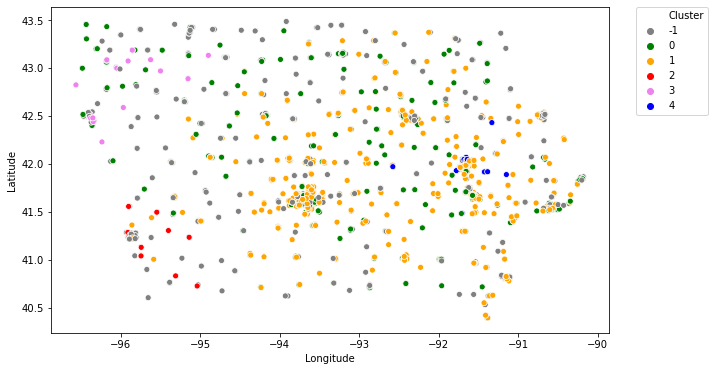

In [3]:
EPSILON = 0.206
N_SAMPLES = 13 # 6

cluster_df = stores19_features.copy()
cluster_scaled = MinMaxScaler().fit_transform(cluster_df.drop(columns=[
#     ('mean','Latitude'),  # To test leaving out location data
#     ('mean','Longitude'), # To test leaving out location data
]))

np.random.seed(31415) # Only to preproduce PNG in README
db = DBSCAN(eps=EPSILON, min_samples=N_SAMPLES).fit(cluster_scaled)
labels = db.labels_

cluster_df['Cluster']=labels

value_counts = pd.DataFrame(cluster_df.Cluster.value_counts())
value_counts = value_counts.sort_index()
value_counts.loc['All','Cluster'] = value_counts.sum().to_list()[0]
value_counts = value_counts.rename(columns={'Cluster':'Store_count'})
display(value_counts)

cluster_numbers = list(value_counts.index)
cluster_numbers.remove(-1)
cluster_renumbering = {val:i for i,val in enumerate(cluster_numbers)}
cluster_renumbering = {-1:-1, **cluster_renumbering}
# cluster_renumbering

# Plot clusters excluding outliers
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
#     data=cluster_df[cluster_df.Cluster!=-1], # Exclude outliers
    data=cluster_df,
    x=('mean','Longitude'),
    y=('mean','Latitude'),
    hue="Cluster",
    legend='full', 
#     palette=plt.get_cmap('Set1'),
    palette='gray green orange red violet blue'.split(),
#     alpha=0.7,
    ax=ax,
)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# plt.xlim(-94,-93) # To check Des Moines region
# plt.ylim(41,42)   # To check Des Moines region

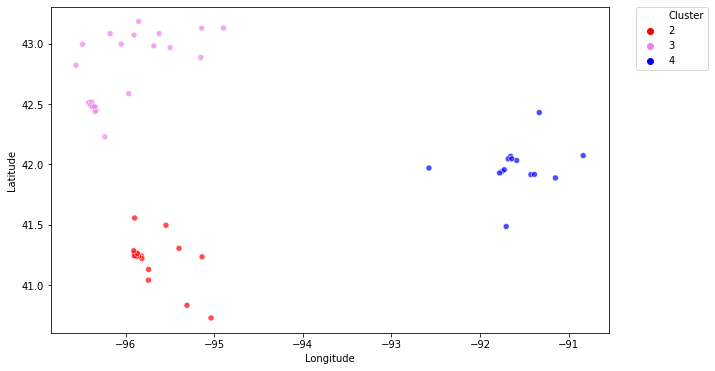

In [4]:
# Plot just clusters 2,3,4
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=cluster_df[cluster_df.Cluster>=2], # Exclude outliers (cluster=-1), nonlocal clusters 0,1
    x=('mean','Longitude'),
    y=('mean','Latitude'),
    hue="Cluster",
    legend='full', 
    palette='red violet blue'.split(),
    alpha=0.7,
    ax=ax,
)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [5]:
cluster_feature_means = pd.concat([
    (
        pd.DataFrame(cluster_df.mean()).T
        .rename(index={0:'All'})
        .drop(columns=['Cluster'])
    ),
    pd.pivot_table(cluster_df,index='Cluster',values=cluster_df.columns,aggfunc='mean'),
])

cluster_feature_means = pd.concat([
    cluster_feature_means,
    value_counts.rename(columns={'Store_count':('count','Store')}),
], axis=1)

cluster_feature_means = cluster_feature_means.rename(index={-1:'-1 (outliers)'})
cluster_feature_means.index.name='Cluster'


pd.set_option('float_format','{:.3f}'.format)
cluster_feature_means[['Cents_pc','mean']]

pd.set_option('float_format','{:.0f}'.format)
cluster_feature_means[['Dol_per_gal','nunique','sum','count']]

Cents_pc                   mean          
Category       Neutral Vodka Whiskey Latitude Longitude
Cluster                                                
All              0.002 0.263   0.331   41.975   -93.052
-1 (outliers)    0.003 0.241   0.324   42.049   -93.264
0                0.003 0.253   0.347   42.072   -93.062
1                0.000 0.293   0.324   41.819   -92.632
2                0.001 0.222   0.318   41.218   -95.726
3                0.000 0.259   0.351   42.741   -96.057
4                0.000 0.319   0.288   41.979   -91.587

Dol_per_gal          nunique                              \
Category              All Tequila Category Invoice Item_num Vendor_num   
Cluster                                                                  
All                    58     109        8    1230      232         28   
-1 (outliers)          62     121        8    1955      348         34   
0                      53      94        9    1364      266         31   
1                      59     110        8     492      106         21   
2                      67     116        7     503       97         21   
3                      56     118        8     510      109         21   
4                      51      91        6     243       63         18   

                   sum count  
Category         Cents Store  
Cluster                       
All           18759543  1578  
-1 (outliers) 34724807   537  
0             17671103   437  
1              5417466   544  
2              6080525    21  
3              4963511    25  
4              2441802    14